### KMeans

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Métricas
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
from scipy.stats import randint
# To save models
import json
import pickle
#para Kmeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="findfont: *")

import matplotlib as mpl
# Configura Matplotlib para usar 'DejaVu Sans' como fuente sans-serif predeterminada
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans']

In [2]:
df = pd.read_csv('../data/processed/df_ini_09housing.csv')

In [3]:
x = df.copy()

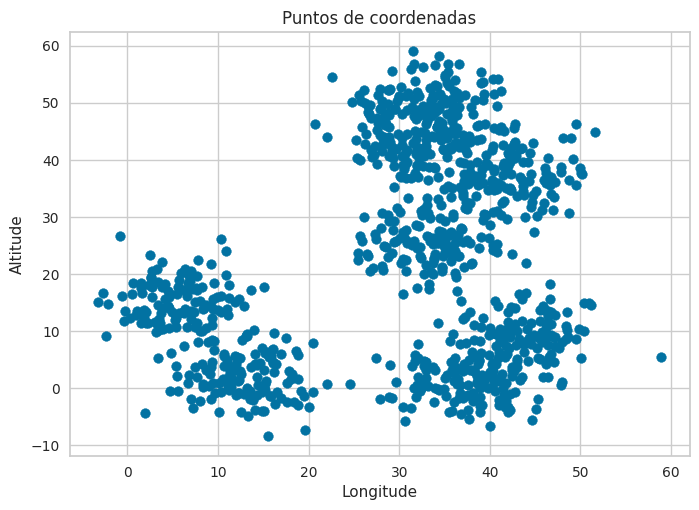

In [4]:
# Generamos el gráfico.
X, _ = make_blobs(center_box=(0,50),
                  n_features=2,
                  n_samples=1000,
                  centers=8,
                  cluster_std=3.8,
                  random_state=18)

plt.scatter(X[:, 0], X[:, 1])
plt.title('Puntos de coordenadas')
plt.xlabel('Longitude')
plt.ylabel('Altitude')
plt.show()

In [5]:
# Escalado de valores Min-Max.
min_max_scaler = MinMaxScaler()
min_max_features = min_max_scaler.fit_transform(df)
df_escalado = pd.DataFrame(min_max_features,
                          index=df.index,
                          columns=df.columns)
df_escalado


,MedInc,Latitude,Longitude
0,0.539668,0.567481,0.211155
1,0.538027,0.565356,0.212151
2,0.466028,0.564293,0.210159
3,0.354699,0.564293,0.209163
4,0.230776,0.564293,0.209163
...,...,...,...
20630,0.073130,0.737513,0.324701
20631,0.141853,0.738576,0.312749
20632,0.082764,0.732200,0.311753
20633,0.094295,0.732200,0.301793


### Elbow

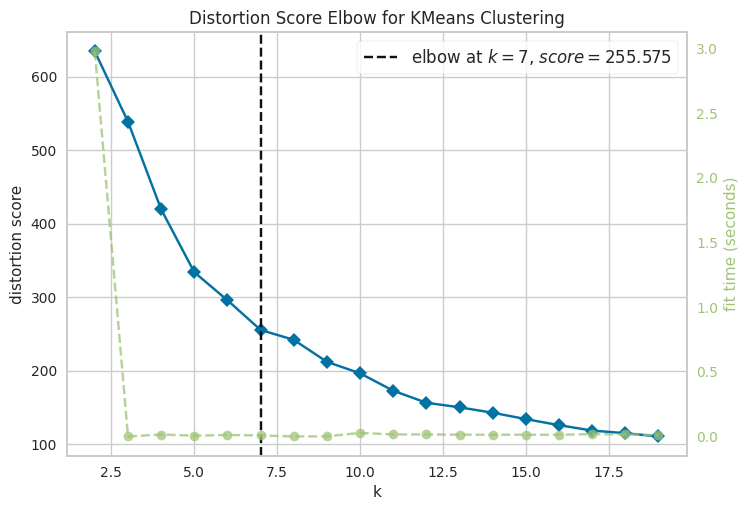

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
elbow_vis = KElbowVisualizer(KMeans(random_state=18), k=(2, 20))
elbow_vis.fit(df_escalado)
elbow_vis.show()

In [7]:
# Aplicamos modelo KMeans
kmeans = KMeans(n_clusters=6, random_state=18)
cluster = kmeans.fit_predict(df_escalado)
cluster

array([4, 4, 4, ..., 1, 1, 1], shape=(20635,), dtype=int32)

In [8]:
df_escalado['cluster'] = cluster
df_escalado

,MedInc,Latitude,Longitude,cluster
0,0.539668,0.567481,0.211155,4
1,0.538027,0.565356,0.212151,4
2,0.466028,0.564293,0.210159,4
3,0.354699,0.564293,0.209163,4
4,0.230776,0.564293,0.209163,1
...,...,...,...,...
20630,0.073130,0.737513,0.324701,1
20631,0.141853,0.738576,0.312749,1
20632,0.082764,0.732200,0.311753,1
20633,0.094295,0.732200,0.301793,1


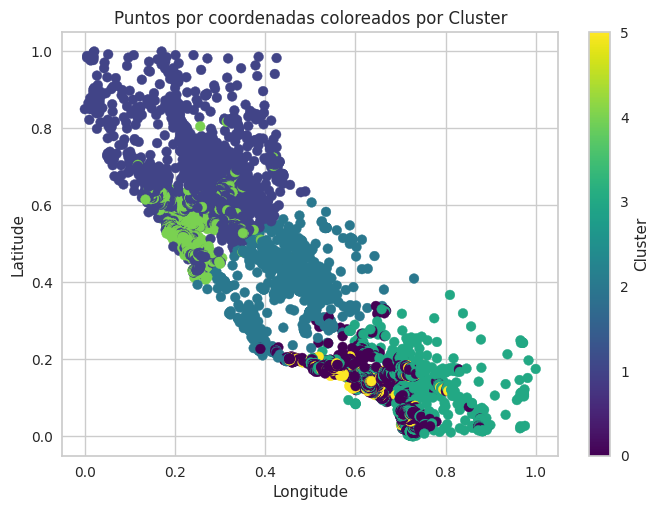

In [9]:
# Gráfico geográfico (Latitud vs Longitud)
scatter = plt.scatter(df_escalado["Longitude"], df_escalado["Latitude"], c=df_escalado["cluster"],cmap='viridis')

plt.title("Puntos por coordenadas coloreados por Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster') 

plt.show()

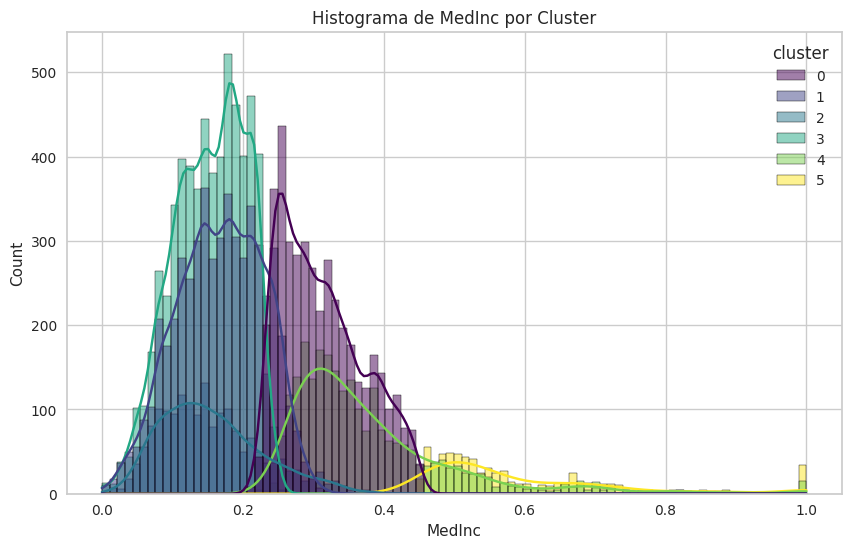

In [10]:
plt.figure(figsize=(10, 6))

# kde=True añade la línea de densidad suave sobre las barras
sns.histplot(data=df_escalado, x="MedInc", hue="cluster", kde=True, palette="viridis")

plt.title("Histograma de MedInc por Cluster")
plt.show()

> ### Observaciones:
> El modelo clasificó basandose en una cantidad de ingresos medio que tiene cada casa. En los casos donde la cantidad de ingresos son parecidos se enfoco en usar latitud y longitud para asignarle un grupo. Dejandonos grupos segun zonas e ingresos medios.

> Como ejemplo para que se entienda, diremos que hay personas con unos ingresos medios-bajos viviendo en zonas con personas que tienen altos ingresos.

##  Entrenamos un modelo de clasificación supervisada.

Ahora que el K-Means nos ha devuelto una categorización (agrupación) de los puntos para los conjuntos de entrenamiento y prueba, estudia qué modelo podría ser más útil y entrénalo. Obtén las estadísticas y describe lo que ves.

Este flujo es muy común cuando contamos con datos no etiquetados: utilizar un modelo de aprendizaje no supervisado para etiquetarlos de forma automática y a continuación, un modelo de aprendizaje supervisado.

### Split

In [11]:
X = df_escalado.drop('cluster', axis=1)
y = df_escalado['cluster']

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)